In [1]:
import pandas as pd
import numpy as np 
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt 
import seaborn as sns
from PIL import Image
import glob

In [2]:
lung_data_path = r"C:\Users\vulo\OneDrive\Documents\GitHub\W207-Spring-2023\Final Project\Dataset\lung_colon_image_set\lung_image_sets"
colon_data_path = r"C:\Users\vulo\OneDrive\Documents\GitHub\W207-Spring-2023\Final Project\Dataset\lung_colon_image_set\colon_image_sets"


colon_path_aca = r'\colon_image_sets\colon_aca'
colon_path_n = r'\colon_image_sets\colon_n'
lung_path_aca = r'\lung_image_sets\lung_aca'
lung_path_n = r'\lung_image_sets\lung_n'
lung_path_scc = r'\lung_image_sets\lung_scc'




In [3]:
# Setting up class
class_image = ['lung_aca','lung_n','lung_scc', 'colon_aca','colon_n']
cancer_class = ['Lung_Adenocarcinoma','Lung_Normal','Lung_Squamous_Cell_Carcinoma','Colon_Adenocarcinoma','Colon_Normal']


In [4]:
# Create training dataset for lung dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory = lung_data_path, 
    batch_size = 25, 
    image_size = (128,128), 
    class_names = class_image,
    seed = 42, 
    subset = 'training',
    validation_split = 0.2)


Found 25000 files belonging to 5 classes.
Using 20000 files for training.


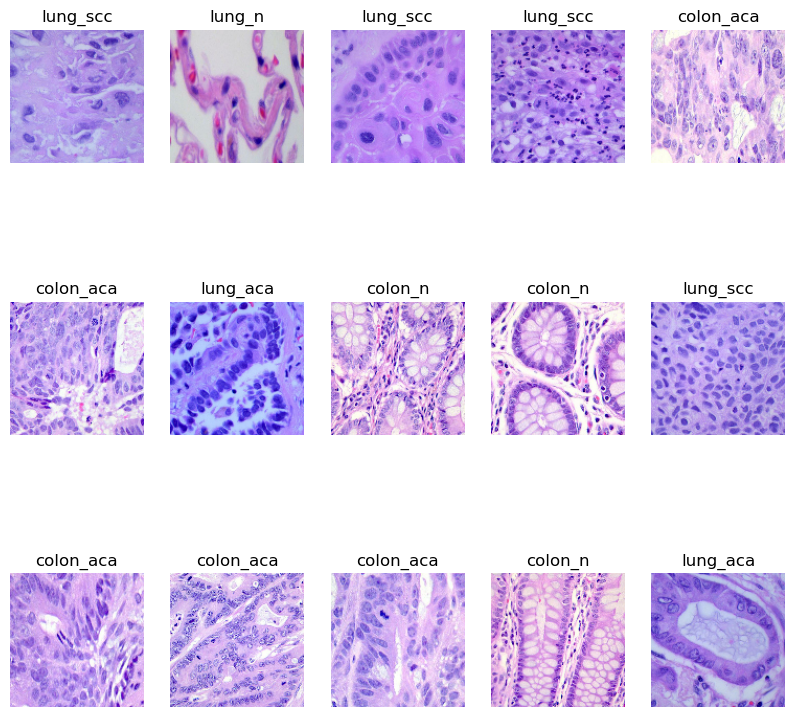

In [5]:
# Display the first 9 images 
import matplotlib.pyplot as plt
plt.figure(figsize = (10,10))
for images, labels in train_ds.take(1): 
    for i in range(15):
        ax = plt.subplot(3,5, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_image[labels[i]])
        plt.axis('off')

In [6]:
for image_batch, label_batch in train_ds: 
    display(image_batch.shape)
    display(label_batch.shape)
    break

TensorShape([25, 128, 128, 3])

TensorShape([25])

In [7]:
# Create testing dataset for lung dataset 
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory = lung_data_path, 
    batch_size = 25, 
    image_size = (128,128), 
    class_names = class_image, 
    seed = 42, 
    subset = 'validation', 
    validation_split = 0.2)

Found 25000 files belonging to 5 classes.
Using 5000 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['lung_aca', 'lung_n', 'lung_scc', 'colon_aca', 'colon_n']


In [9]:
# Autotune to increase computer performance on image processing
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)


In [10]:
# Standardization on lung dataset
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
#image_batch, labels_batch = next(iter(normalized_lung_train_ds))
#first_image = image_batch[0]
#print(np.min(first_image), np.max(first_image))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [39]:
X_train = tf.concat([x for x, y in train_ds], axis = 0)
X_train = np.array(X_train) 
y_train = tf.concat([y for x, y in train_ds], axis = 0) 
y_train = np.array(y_train)

In [40]:
X_test = tf.concat([x for x, y in test_ds], axis = 0)
X_test = np.array(X_test) 
y_test = tf.concat([y for x, y in test_ds], axis = 0) 
y_test = np.array(y_test)

In [41]:
y_train = y_train.flatten()
y_test = y_test.flatten()

In [42]:
X_train.size

983040000

In [14]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [15]:
gray = map(rgb2gray, X_train)
X_train = np.array(list(gray))
X_train = X_train/255
X_train.shape

(20000, 128, 128)

In [16]:
gray_test = map(rgb2gray, X_test)
X_test = np.array(list(gray_test))
X_test = X_test/255
X_test.shape

(5000, 128, 128)

In [17]:
def build_model(n_classes,
                hidden_layer_sizes=[],
                activation='relu',
                optimizer='Adam',
                learning_rate=0.01):
  """Build a multi-class logistic regression model using Keras.

  Args:
    n_classes: Number of output classes in the dataset.
    hidden_layer_sizes: A list with the number of units in each hidden layer.
    activation: The activation function to use for the hidden layers.
    optimizer: The optimizer to use (SGD, Adam).
    learning_rate: The desired learning rate for the optimizer.

  Returns:
    model: A tf.keras model (graph).
  """
  tf.keras.backend.clear_session()
  np.random.seed(0)
  tf.random.set_seed(0)

  # YOUR CODE HERE
  
  model = tf.keras.Sequential()
  if optimizer == 'SGD': 
    optimizer_func = keras.optimizers.SGD(learning_rate = learning_rate)
  else: 
    optimizer_func = keras.optimizers.Adam(learning_rate = learning_rate)
  
  

  model.add(keras.layers.Flatten(name = 'Input'))
  for hidden_layer in hidden_layer_sizes: 
        model.add(keras.layers.Dense(units = hidden_layer, 
                                       activation = activation))
  model.add(keras.layers.Dense(units = n_classes, activation = 'softmax', name = 'Output'))
  model.compile(loss = 'sparse_categorical_crossentropy',
                optimizer = optimizer_func, 
                metrics = ['accuracy'])

  return model

In [36]:
model = build_model(n_classes=len(class_image),
                   hidden_layer_sizes = [],
                   activation = 'relu',
                   optimizer = 'Adam', 
                   learning_rate = 1)

In [37]:
epochs = 30
history = model.fit(
  x = X_train,
  y = y_train,
  epochs=epochs,
  batch_size=64,
  validation_split=0.1,
  verbose=1)

Epoch 1/30
282/282 [==============================] - 1s 4ms/step - loss: 4118.6831 - accuracy: 0.1968 - val_loss: 4065.0022 - val_accuracy: 0.2110
Epoch 2/30
282/282 [==============================] - 1s 4ms/step - loss: 3120.4814 - accuracy: 0.2046 - val_loss: 3480.2175 - val_accuracy: 0.1895
Epoch 3/30
282/282 [==============================] - 1s 4ms/step - loss: 2970.9861 - accuracy: 0.2022 - val_loss: 2487.1978 - val_accuracy: 0.1905
Epoch 4/30
282/282 [==============================] - 1s 4ms/step - loss: 2762.8682 - accuracy: 0.2084 - val_loss: 1837.7654 - val_accuracy: 0.2115
Epoch 5/30
282/282 [==============================] - 1s 4ms/step - loss: 3078.1797 - accuracy: 0.2052 - val_loss: 2546.2529 - val_accuracy: 0.1955
Epoch 6/30
282/282 [==============================] - 1s 4ms/step - loss: 3198.6243 - accuracy: 0.2089 - val_loss: 3813.4009 - val_accuracy: 0.2110
Epoch 7/30
282/282 [==============================] - 1s 4ms/step - loss: 2868.3250 - accuracy: 0.2119 - val_los

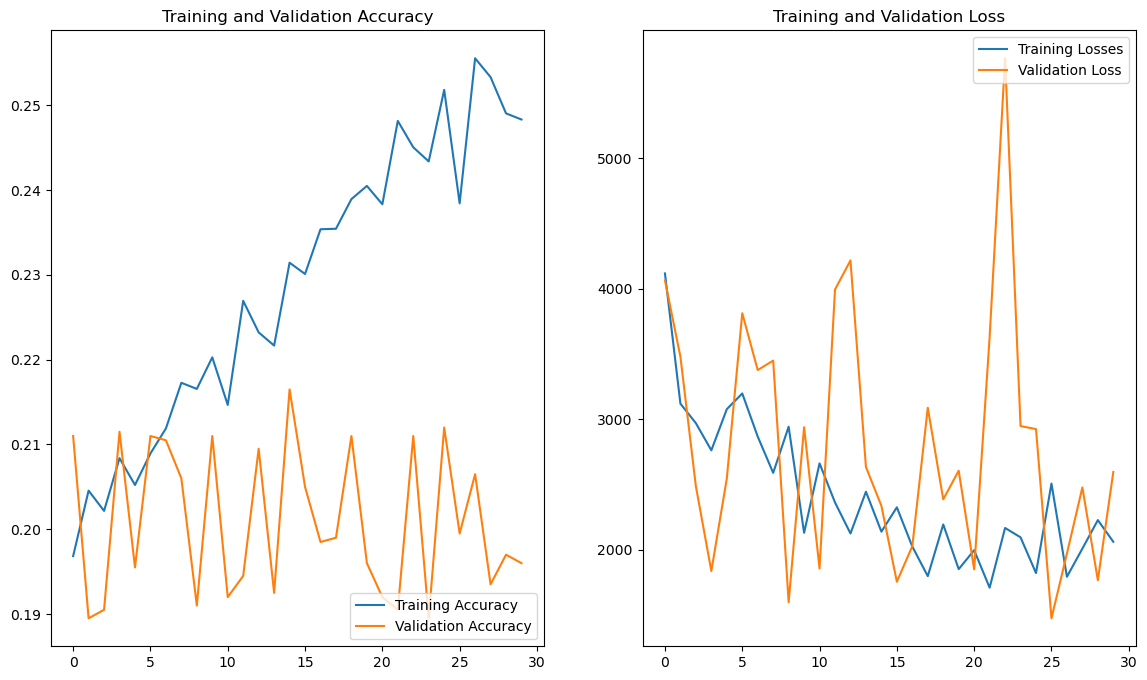

In [38]:
epochs = 30
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)
plt.figure(figsize = (14,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2) 
plt.plot(epochs_range, loss, label = 'Training Losses')
plt.plot(epochs_range, val_loss, label = 'Validation Loss') 
plt.legend(loc = 'upper right') 
plt.title('Training and Validation Loss')
plt.show()

In [33]:
# Predicting the modeling 
pred = np.argmax(model.predict(X_test), axis = -1)
# Add confusion matrix 
# ROC curve 
# AUC curve
print(pred)

157/157 [==============================] - 0s 1ms/step
[3 3 3 ... 3 3 3]


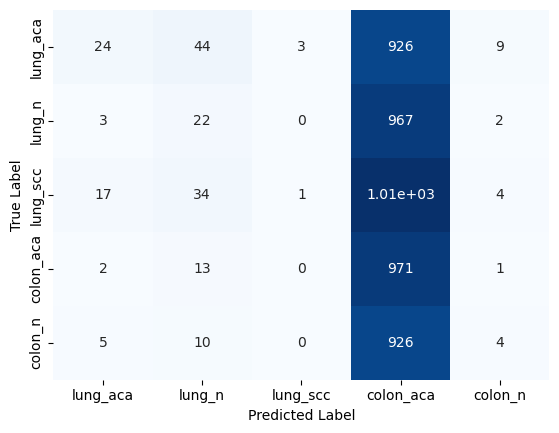

In [34]:
# Extract y label in test dataset 
y_test = tf.concat([y for x, y in test_ds], axis=0)
y_test = np.array(y_test)

# Confusion matrix
confusion_matrix = tf.math.confusion_matrix(y_test, pred)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=class_image, yticklabels=class_image, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()


ROC AUC score: 0.5043619615441507


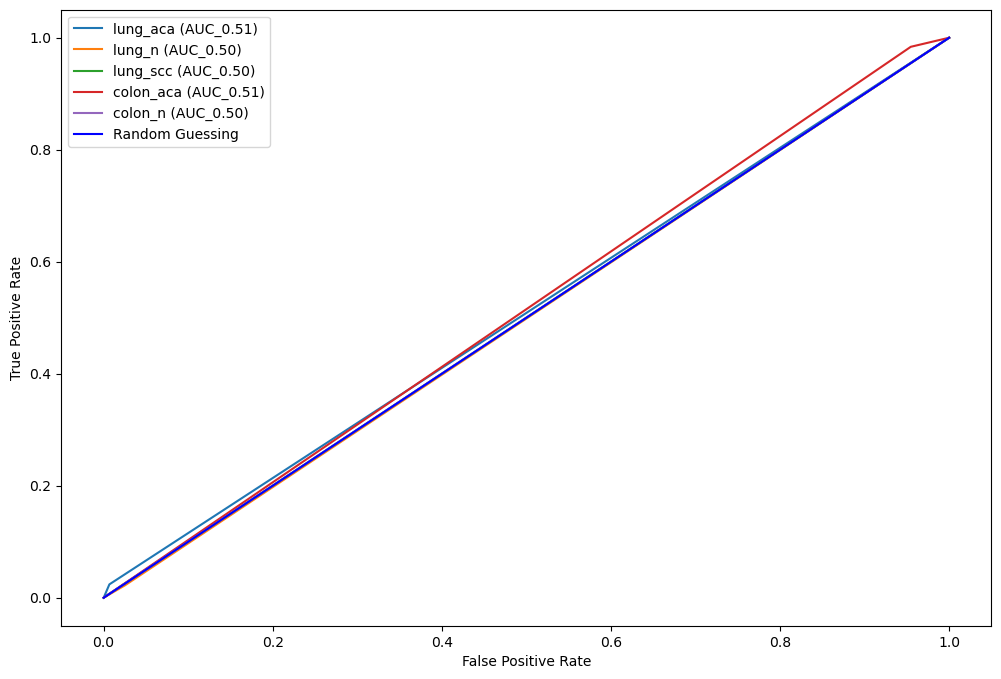

In [35]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Plot linewidth.
lw = 2

# set plot figure size 
fig, c_ax = plt.subplots(1,1, figsize = (12,8))

# function for scoring roc auc score for multi-class 
def multiclass_roc_auc_score(y_test, pred, average = 'macro'):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    pred = lb.transform(pred)
    
    for (idx, c_label) in enumerate(class_image):
        fpr, tpr, thresholds = roc_curve(y_test[:, idx].astype(int), pred[:, idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC_%0.2f)' % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, pred, average = average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test, pred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()
